#NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2022/23 (6 CFU) - Dr. Jacopo Pegoraro, Dr. Daniele Mari
---


## Lab. 07 - Generative Adversarial Networks

**GANs** are a form of neural network composed by 2 subnetworks:
*   a *Generator* that is trained to produce data which is indiscernable from the true data,
*   a *Discriminiator* that is trained to discern between the real and generated data.

The overall network is trained with a **minimax loss function**:

$ \min_{G} \max_{D} {V(D,G)}=\mathbb{E}_x[log(D(x))] + \mathbb{E}_z[log(1-D(G(z)))]$


In this function:

* $D(x)$ is the discriminator's estimate of the probability that real data instance $x$ is real.
* $\mathbb{E}_x$ is the expected value over all real data instances.
* $G(z)$ is the generator's output when given noise $z$.
* $D(G(z))$ is the discriminator's estimate of the probability that a fake instance is real.
* $\mathbb{E}_z$ is the expected value over all random inputs to the generator (in effect, the expected value over all generated fake instances $G(z)$).

The formula derives from the cross-entropy between the real and generated distributions.

The two subnetworks play a two players **minimax game** with value function $V(D, G)$, where:
* the *Generator* tries to *maximize* the overall loss function,
* the *Discriminator* tries to *minimize* the overall loss function.

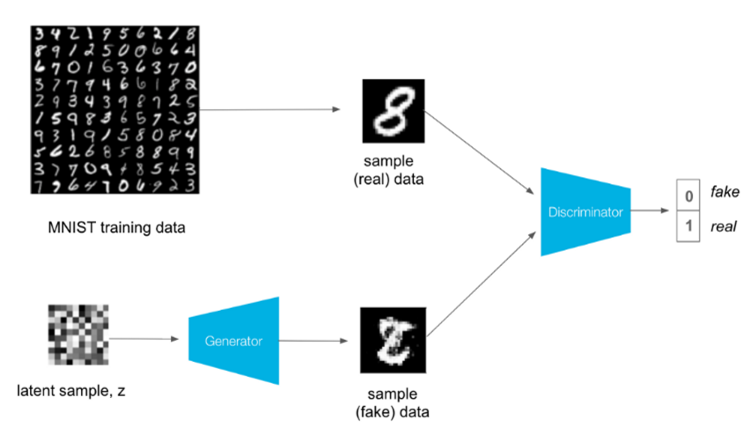


---
#### References
[1] I Goodfellow, J Pouget-Abadie, M Mirza, B Xu, D Warde-Farley, S Ozair, Y. Bengio. Advances in neural information processing systems, 2672-2680. https://arxiv.org/abs/1406.2661

### Setup

In [1]:
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import time as time
import numpy as np
from IPython import display

### Load and prepare the dataset

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

Dataset **MNIST digits** contains 60,000 examples for training and 10,000 examples for testing.
The digits are size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 255.

100%|██████████| 9912422/9912422 [00:00<00:00, 68692933.79it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 5119419.06it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 26118992.83it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7227059.47it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



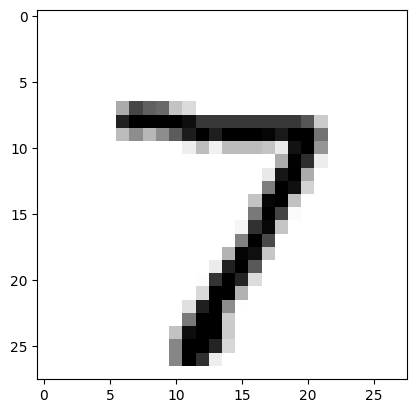

Image size torch.Size([1, 28, 28])
Label 7


In [2]:
dataset = MNIST(root="./", train=False, download=True, transform=ToTensor())
image, label = dataset.__getitem__(0)
plt.imshow(image.squeeze(0),cmap="binary")
plt.show()
print("Image size", image.shape)
print("Label", label)

In [3]:
BATCH_SIZE = 128
device = "cuda" if torch.cuda.is_available() else "cpu"
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count())

## Create the models


### The Generator

The generator uses `ConvTranspose2d` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `LeakyReLU` activation for each layer, except the output layer which can use `Sigmoid` to predict pixel values in the [0, 1] range.

The architecture is as follows:
* Linear Layer with size 256\*7\*7, Batch Normalization and LeakyRelu
* Reshape to (batch_size, 256, 7, 7)
* Transposed Convolution with 128 filters, kernel size = 5 no bias and padding = 2 BatchNorm and LeakyRelu
* Transposed Convolution with 64 filter, kernel size = 5, no bias, stride=2, padding = 2 and ouput_padding=1 BatchNorm and LeakyRelu
* Transposed Convolution with 1 filter, kernel size = 5, no bias, stride=2, padding = 2 and ouput_padding=1 and Sigmoid

In [9]:
class Generator(nn.Module):

    def __init__(self, input_size):

        super().__init__()

        self.input_size = input_size

        self.fc_net = nn.Sequential(
            nn.Linear(input_size, 256*7*7, bias=False),
            nn.BatchNorm1d(256*7*7),
            nn.LeakyReLU()
        )

        self.conv_model = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 5, bias=False, padding=2),
            nn.BatchNorm2d((128)),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, 5, bias=False, stride=2, padding=2, output_padding=1),
            nn.BatchNorm2d((64)),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 1, 5, bias=False, stride=2, padding=2, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.fc_net(x)
        y = y.reshape((-1, 256, 7, 7))
        y = self.conv_model(y)
        return y

In [10]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.xavier_uniform_(m.weight.data)
    if classname.find('Linear') != -1:
        nn.init.xavier_uniform_(m.weight.data)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.2)
        nn.init.constant_(m.bias.data, 0)

Produce a noise vector of size `[1, 100]` and use the (as yet **untrained**) generator to create an image.

In [11]:
generator = Generator(100)
generator.apply(weights_init)

Generator(
  (fc_net): Sequential(
    (0): Linear(in_features=100, out_features=12544, bias=False)
    (1): BatchNorm1d(12544, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (conv_model): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): ConvTranspose2d(64, 1, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
    (7): Sigmoid()
  )
)

torch.Size([10, 100])
torch.Size([10, 1, 28, 28])


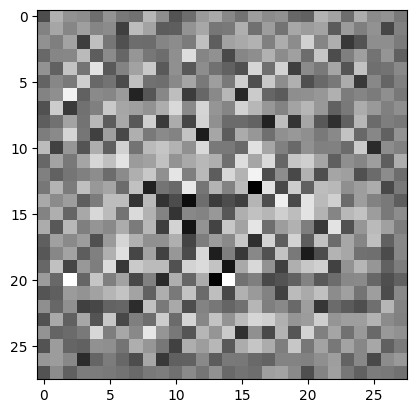

In [12]:
############################ CODE HERE ###############################
noise = torch.normal(0, 1, [10, 100])
print(noise.shape)
generated_image = generator(noise).detach()
print(generated_image.shape)
############################ CODE HERE ###############################

plt.imshow(generated_image.squeeze()[0], cmap='gray')

Visualize the model.

### The Discriminator

The discriminator is a CNN-based image classifier.
The layer are as follows:
* Convolutional layer with 64 filters, kernel_size=5, stride = 2, padding=2 with LeakyRelu and Dropout with rate 0.3
* Convolutional layer with 128 filters, kernel_size=5, stride = 2, padding=2 with LeakyRelu and Dropout with rate 0.3
* Convolutional layer with 256 filters, kernel_size=5, stride = 2, padding=2 with LeakyRelu and Dropout with rate 0.3
* Flatten layer
* Linear Layer with one output for "fake or real" classification.


In [13]:
class Discriminator(nn.Module):

    def __init__(self):

        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 64, 5, stride=2, padding=2),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, 5, stride=2, padding=2),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(128, 128, 5, stride=2, padding=2),
            nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Flatten(),
            nn.Linear(2048, 1)
        )


    def forward(self, x):
        y = self.model(x)
        return y

Use the (yet **untrained**) discriminator to classify the generated images as real or fake. The model will be trained to output the probability that the image is real.

In [14]:
discriminator = Discriminator()
discriminator.apply(weights_init)

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (4): LeakyReLU(negative_slope=0.01)
    (5): Dropout(p=0.3, inplace=False)
    (6): Conv2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (7): LeakyReLU(negative_slope=0.01)
    (8): Dropout(p=0.3, inplace=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=2048, out_features=1, bias=True)
  )
)

In [15]:
############################ CODE HERE ###############################
decision = discriminator(generated_image)
############################ CODE HERE ###############################
print(decision)

tensor([[ 0.0665],
        [ 0.0390],
        [-0.0166],
        [-0.0184],
        [ 0.0903],
        [-0.0433],
        [-0.0270],
        [-0.0057],
        [-0.1061],
        [ 0.0449]], grad_fn=<AddmmBackward0>)


## Define the loss and optimizers

Define loss functions and optimizers for both models.


### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.
The discriminator loss is of the form:

$\frac{1}{m}\sum_{i=1}^{m}[\log D(\boldsymbol{x}^{(i)}) +\log(1-D(G(\boldsymbol{z}^{(i)})))]$


In [16]:
cross_entropy = nn.BCEWithLogitsLoss()
def discriminator_loss(real_output, fake_output, device):
    ############################ CODE HERE ###############################
    real_loss = cross_entropy(real_output, torch.ones_like(real_output, device=device))
    fake_loss = cross_entropy(fake_output, torch.zeros_like(fake_output, device=device))
    total_loss = real_loss + fake_loss
    ############################ CODE HERE ###############################
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1).
The generator loss is of the form:

$\frac{1}{m}\sum_{i=1}^{m}\log(1-D(G(\boldsymbol{z}^{(i)})))$

However in the original paper they show that this loss has some convergence issues when the discriminator is too good at recognizing fake samples leading to issues in the training. So instead usually the loss

$\frac{1}{m}\sum_{i=1}^{m}-\log(D(G(\boldsymbol{z}^{(i)})))$

Which is the Binary crossentropy between $D(G(\boldsymbol{z}^{(i)}))$ and the probability distribution that has $y^{(i)} = 1 \forall i$, i.e. we are forcing the generator to produce samples that will make the discriminator predict that fake samples are real.

In [17]:
def generator_loss(fake_output, device):
    ############################ CODE HERE ###############################
    gen_loss = cross_entropy(fake_output, torch.ones_like(fake_output, device=device))
    ############################ CODE HERE ###############################
    return gen_loss

The discriminator and the generator optimizers are different since you will train two networks separately.

In [18]:
gen_opt = torch.optim.Adam(generator.parameters(), lr=2e-4)
dis_opt = torch.optim.Adam(discriminator.parameters(), lr=2e-4)

## Define the training loop


In [19]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16
seed = torch.randn([num_examples_to_generate, noise_dim], device=device)

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [20]:
def train_step(images, generator, discriminator, BATCH_SIZE, noise_dim, device, dis_opt, gen_opt):
    noise = torch.randn([BATCH_SIZE, noise_dim], device=device)

    # Generate Images
    generated_images = generator(noise)

    # Classify true and fake images (remember to stop gradient using detach when predicting fake images)
    real_output = discriminator(images)
    fake_output = discriminator(generated_images.detach())

    # Compute discriminator loss and update discriminator
    disc_loss = discriminator_loss(real_output, fake_output, device)
    dis_opt.zero_grad()
    disc_loss.backward()
    dis_opt.step()

    # Compute predictions where gradients can flow to the generator of fake samples
    fake_output = discriminator(generated_images)

    # Compute generator loss and update generator
    gen_loss = generator_loss(fake_output, device)
    gen_opt.zero_grad()
    gen_loss.backward()
    gen_opt.step()

    return gen_loss, disc_loss

In [21]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    model.eval()
    with torch.no_grad():
        predictions = model(test_input).detach().cpu()* 250

    grid = make_grid(predictions, 4).numpy().squeeze().transpose(1, 2, 0)

    plt.imshow(grid.astype(np.uint8) , cmap='binary')
    plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

    model.train()

In [22]:
def train(dataloader, epochs, generator, discriminator, BATCH_SIZE, noise_dim, device, dis_opt, gen_opt):
  gloss = []
  dloss = []
  for epoch in range(epochs):
    start = time.time()

    gen_losses = []
    disc_losses = []
    for image_batch, _ in dataloader:
        image_batch = image_batch.to(device)
        gen_loss, disc_loss = train_step(image_batch, generator, discriminator, BATCH_SIZE, noise_dim, device, dis_opt, gen_opt)
        gen_losses.append(gen_loss.detach().cpu())
        disc_losses.append(disc_loss.detach().cpu())

    gloss.append(np.mean(gen_losses))
    dloss.append(np.mean(disc_losses))
    #Produce images
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  return gloss, dloss

## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously  for `EPOCH` epochs. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

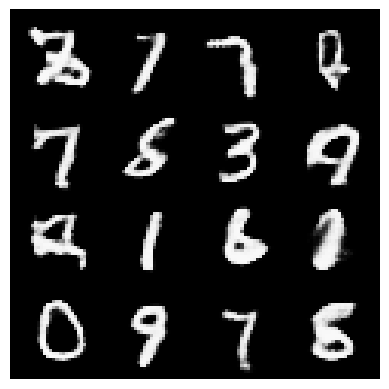

In [23]:
############################ CODE HERE ###############################
generator.to(device)
discriminator.to(device)
gloss, dloss = train(dataloader, EPOCHS, generator, discriminator, BATCH_SIZE, noise_dim, device, dis_opt, gen_opt)
############################ CODE HERE ###############################

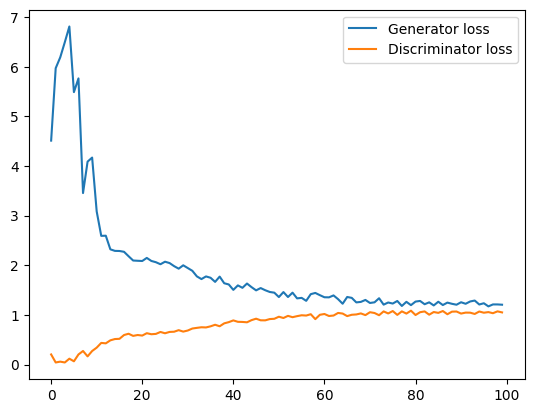

In [24]:
plt.plot(gloss, label="Generator loss")
plt.plot(dloss, label="Discriminator loss")
plt.legend()
plt.show()